### import necessary libraries

In [1]:
import numpy as np
from typing import List, Tuple

### ANN class

In [2]:
class ANN:
    """
    Class representation of an artificial neural network (ANN).
    """
    def __init__(self, layers: List[int]):
        """
        Initialization function to set up the class.
        :param layers: Number of neurons for each layer that should be set up as List of ints.
        """
        self.W = dict()  # holding the weight matrices
        self.b = dict()  # holding the bias values
        self.z = dict()  # holding the intermediate values
        self.a = dict()  # holding the activation values
        
        self.dW = dict()  # holding the gradient of the weight matrices
        self.db = dict()  # holding the gradient of the bias values
        
        self.layers = layers  # User defined layers

        self._construct()
        
    def _construct(self):
        """
        Construct the internal shape of the ANN.
        """
        for idx, layer in enumerate(self.layers[:-1]):
            self.W[idx] = np.random.randn(layer, self.layers[idx+1])
            self.b[idx] = np.zeros(self.layers[idx+1])
            
    def loss(self, y: np.ndarray, gradient: bool = False) -> np.ndarray:
        """
        Compute the cross entropy loss for the given hypothesis (h) in contrast to the true results (y).
        If the gradient flag is True, the derivative of said loss function will be returned.
        :param y: True output data.
        :param gradient: Bool flag to indicate if gradient should be returned.
        :return: Cost/Loss of the current hypothesis.
        """
        h = self.a[len(self.layers)-2]  # our prediction / hypothesis
        
        if gradient:
            return -(y // h) + ((1 - y) // (1 - h))
        return -(1/y.size) * ((y.T @ np.log(h)) + ((1 - y.T) @ np.log(1 - h)))
    
    def activation(self, X: np.ndarray, gradient: bool = False) -> np.ndarray:
        """
        For the activation function we use the sigmoid.
        It will return 0 for every x << 0 and 1 for every x >> 0.
        Return the gradient of the sigmoid if a True gradient flag is given.
        :param X: data to transform via sigmoid function:
        :return: transformed data that lies between 0 and 1.
        """
        sigmoid = 1 / (1 + np.exp(-X))
        if gradient:
            return sigmoid * (1 - sigmoid)
        return sigmoid
    
    def forward(self, X: np.ndarray):
        """
        Successively propagate the input data (X) through the ANN and store all
        intermediate and activation values in their corresponding dictionaries.
        :param X: Input data to make predictions on.
        """
        self.a[-1] = X
        for idx in range(len(self.layers)-1):
            self.z[idx] = self.a[idx-1] @ self.W[idx] + self.b[idx]
            self.a[idx] = self.activation(self.z[idx])

    def backward(self, y: np.ndarray):
        """
        Successively propagate the prediction as well as the true output backwards through the ANN.
        Store the resulting gradients for weights and biases in their corresponding dictionaries.
        :param y: True output data.
        """
        da = self.loss(y=y, gradient=True)  # get gradient of last activation value
        
        for idx in range(len(self.layers)-2, -1, -1):  # loop from the last layer to zero (effectively)
            dz = da * self.activation(X=self.z[idx], gradient=True)
            da = dz @ self.W[idx].T  

            self.db[idx] = np.mean(dz, axis=0)  # get gradient of bias. use mean to pay respect to sample size.
            self.dW[idx] = (self.a[idx-1].T @ dz) / y.size  # get gradient of weights. divide by number of samples.     
            
    def predict(self, X: np.ndarray, threshold: float = 0.5) -> np.ndarray:
        """
        Predict the output of the given data (X).
        :param X: Data to make prediction on.
        :param threshold: Threshold that decides if predicted value belongs to class 0 or 1.
        :return: Predicted value.
        """
        self.forward(X)
        return self.a[len(self.layers)-2] > threshold

    def update(self, learning_rate: float):
        """
        Update the current weights and biases by multiplying the learning rate with the previously computed gradients.
        :param learning_rate: The step size of the gradient applied to update the weights and biases (e.g. to learn).
        """
        for idx in range(len(self.layers)-1):
            self.W[idx] -= learning_rate * self.dW[idx]
            self.b[idx] -= learning_rate * self.db[idx]        
        
    def fit(self, X: np.ndarray, y: np.ndarray, learning_rate: float = 1, epochs: int = 1000) -> List:
        """
        Run the training procedure on the given data for the given epochs.
        This essentially fits the network to the given data.
        Print current loss value every epoch.
        :param X: Input data.
        :param y: True output data.
        :param learning_rate: The step size of the gradient applied to update the weights and biases (e.g. to learn).
        :param epochs: Number of training cycles to perform.
        :return: List of loss for each epoch.
        """
        loss_history = []
        
        for epoch in range(epochs):
            self.forward(X=X)
            loss = self.loss(y=y)
            self.backward(y=y)
            self.update(learning_rate)
            
            loss_history.append(loss.item())
            print(f"({epoch+1}/{epochs}): {loss.item()}")
            
        return loss_history

    def accuracy(self, X: np.ndarray, y: np.ndarray) -> float:
        """
        Perform predictions on all the given data (X) and compare these predictions to the ground truth values (y).
        Afterwards get the ratio of correctly to correctly+incorrectly predicted classes. This is the accuracy.
        :param X: Input data.
        :param y: True output data.
        :return: Accuracy as float value.
        """
        return np.sum(self.predict(X) == y) / y.size

### Toy data

In [3]:
def generate_data(N: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Original code credits to Prof. Dr. Stefan Harmeling
    
    Generate a data for training our linear model.
    :param N: number of samples multiplier.
    :return: tuple of x and y data as numpy ndarrays.
    """
    X = np.repeat(np.array([[0, 0], [0, 1], [1, 0], [1, 1]]), N, axis=0)
    X = X + np.random.randn(4 * N, 2) * 0.2
    y = np.repeat([0, 1, 1, 0], N)
    y = np.reshape(y, (len(y), 1))

    return X, y

In [4]:
X_train, y_train = generate_data(N=100)
X_test, y_test = generate_data(N=50)

### Training and testing

In [5]:
model = ANN([2,3,1])
loss = model.fit(X_train, y_train)

(1/1000): 0.6892518498939255
(2/1000): 0.679296384633043
(3/1000): 0.6783986626044629
(4/1000): 0.6780562707383547
(5/1000): 0.6774955537420951
(6/1000): 0.677130484572787
(7/1000): 0.6766311443425543
(8/1000): 0.6763047304593589
(9/1000): 0.6758322048967575
(10/1000): 0.675578485761794
(11/1000): 0.6749954998557997
(12/1000): 0.6752232348740023
(13/1000): 0.6750173927885016
(14/1000): 0.6741560647110427
(15/1000): 0.6739269563505269
(16/1000): 0.6733661795102854
(17/1000): 0.6739234719687689
(18/1000): 0.6743597957472046
(19/1000): 0.6725458139178224
(20/1000): 0.6722962011373365
(21/1000): 0.6719445742035015
(22/1000): 0.6718235806778384
(23/1000): 0.6713501680589041
(24/1000): 0.6717572563691054
(25/1000): 0.6723255889873003
(26/1000): 0.6704987586020041
(27/1000): 0.6700056824552161
(28/1000): 0.6702513950602088
(29/1000): 0.6706114114832713
(30/1000): 0.6693198192471483
(31/1000): 0.6689011314924258
(32/1000): 0.6691002940580566
(33/1000): 0.6695767569928768
(34/1000): 0.667987025

(367/1000): 0.36811712268324526
(368/1000): 0.36684469794692853
(369/1000): 0.36557270747894893
(370/1000): 0.36430121934652476
(371/1000): 0.3630303021355368
(372/1000): 0.3617600247388515
(373/1000): 0.3604849372416862
(374/1000): 0.35921882658293913
(375/1000): 0.35797641854256707
(376/1000): 0.3567298052407376
(377/1000): 0.3554839157991708
(378/1000): 0.3542387878774876
(379/1000): 0.35299446368988635
(380/1000): 0.35175098936261046
(381/1000): 0.35051258958825515
(382/1000): 0.34926916791190293
(383/1000): 0.3480349631312471
(384/1000): 0.34679473149523227
(385/1000): 0.3455556356025106
(386/1000): 0.3443177601742516
(387/1000): 0.3430811847715877
(388/1000): 0.3418459846488207
(389/1000): 0.3406122314693864
(390/1000): 0.339393959597181
(391/1000): 0.33817565708258635
(392/1000): 0.3369575334353139
(393/1000): 0.33573983640998806
(394/1000): 0.33452281673265566
(395/1000): 0.3333067104051907
(396/1000): 0.3320917311400611
(397/1000): 0.33087806841446715
(398/1000): 0.32968149316

(735/1000): 0.11986982759009926
(736/1000): 0.11966235431818778
(737/1000): 0.11945587948430252
(738/1000): 0.11925039950806338
(739/1000): 0.11904591077489743
(740/1000): 0.11884240963664153
(741/1000): 0.11863989241214773
(742/1000): 0.1184399766133414
(743/1000): 0.11824078535434791
(744/1000): 0.11804236081627024
(745/1000): 0.11784473598603304
(746/1000): 0.11764793631928284
(747/1000): 0.11745198118540369
(748/1000): 0.11725688508272303
(749/1000): 0.11706265863850235
(750/1000): 0.11686930941951434
(751/1000): 0.11667684258202166
(752/1000): 0.11648526138885969
(753/1000): 0.11630098880309697
(754/1000): 0.11611024471307492
(755/1000): 0.11592058565158389
(756/1000): 0.1157384286122435
(757/1000): 0.11554984413220315
(758/1000): 0.11536901427864611
(759/1000): 0.11518172283768648
(760/1000): 0.11500915308424556
(761/1000): 0.11482234159772839
(762/1000): 0.11464371679054168
(763/1000): 0.11446558003671559
(764/1000): 0.11428798203289801
(765/1000): 0.11411096393513039
(766/1000)

In [6]:
model.accuracy(X_train, y_train)

0.975

In [7]:
model.accuracy(X_test, y_test)

0.98

### Plot the learning curve

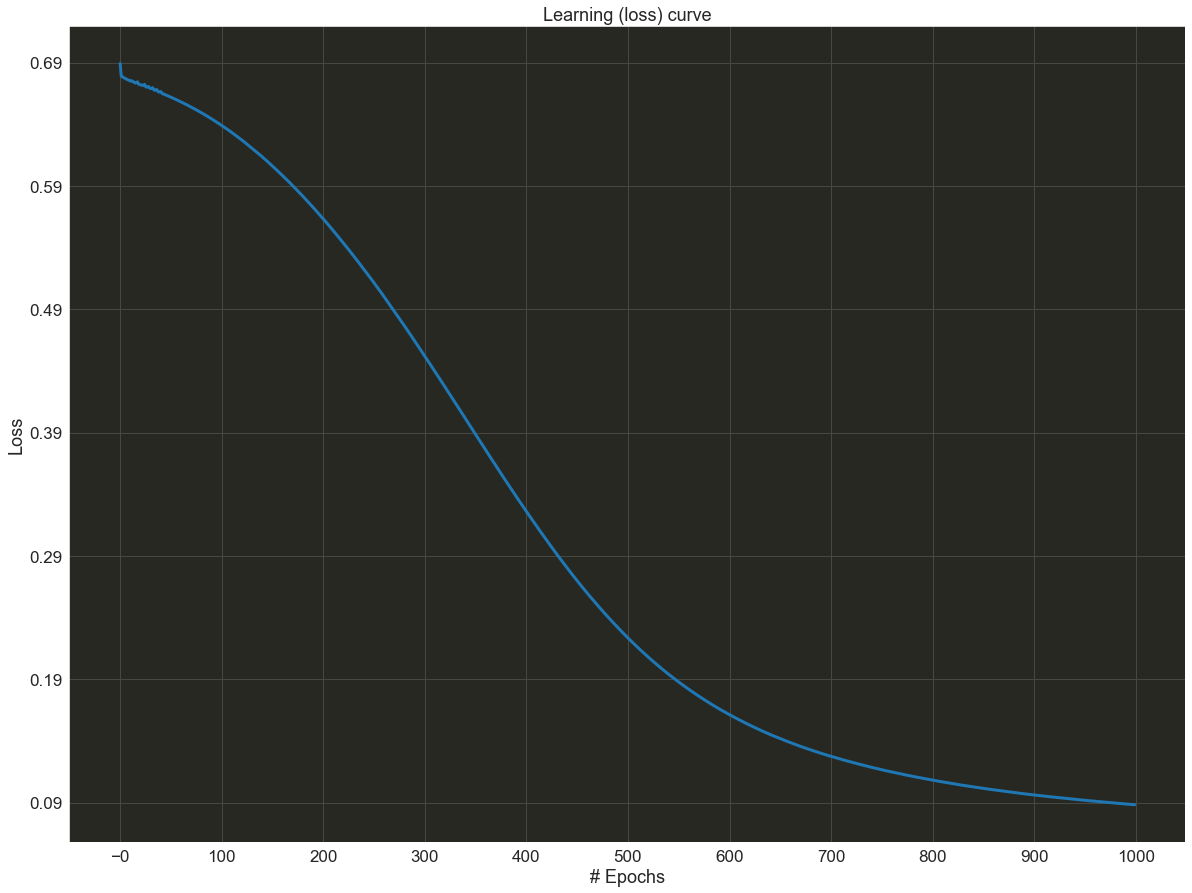

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams.update({"savefig.facecolor": (0.0, 0.0, 0.0, 0.0),})

plt.figure(figsize=(20, 15))

plt.xticks(np.arange(-.01, 1000.01, 100), fontsize=17)
plt.yticks(np.arange(-.01, 1.01, .1), fontsize=17)

ax = plt.gca()
ax.set_facecolor("#272822")
ax.grid(axis='both', visible=True, color='#474842', linestyle='-', linewidth=1)

plt.title("Learning (loss) curve", fontsize=18)
plt.xlabel("# Epochs", fontsize=18)
plt.ylabel("Loss", fontsize=18)
plt.plot([epoch for epoch in range(1000)], loss, linewidth=3)

plt.savefig("learning_curve.svg")
plt.show()